Import libraries

In [1]:
pip install infomap

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install community


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: certifi>=2017.4.17 in c:\users\aless\anaconda3\lib\site-packages (from requests->community) (2022.12.7)



In [3]:
pip install python-louvain

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install mycolorpy

Note: you may need to restart the kernel to use updated packages.


In [5]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nx_comm
from infomap import Infomap
from collections import defaultdict
import numpy as np
import seaborn as sns
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF
from networkx.algorithms import approximation
import community.community_louvain as louvain
from mycolorpy import colorlist as mcp
from community.community_louvain import induced_graph
from statistics import mean
import random

In [6]:
nodes = pd.read_csv("musae_facebook_target.csv")
nodes.head(10)

,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician
5,5,134464673284112,Victor Dominello MP,politician
6,6,282657255260177,Jean-Claude Poissant,politician
7,7,239338246176789,Deputado Ademir Camilo,politician
8,8,544818128942324,T.C. Mezar-ı Şerif Başkonsolosluğu,government
9,9,285155655705,Army ROTC Fighting Saints Battalion,government


In [7]:
#Display unique values in the 'page_type' column
unique_page_types = nodes['page_type'].unique()
print("Unique Page Types:", unique_page_types)

#Count the number of pages for each type
page_type_counts = nodes['page_type'].value_counts()
print("\nNumber of Pages for Each Type:")
print(page_type_counts)

Unique Page Types: ['tvshow' 'government' 'company' 'politician']

Number of Pages for Each Type:
government    6880
company       6495
politician    5768
tvshow        3327
Name: page_type, dtype: int64


In [8]:
edges = pd.read_csv("musae_facebook_edges.csv")
edges.head()

,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


In [9]:
edges.columns = ["Source", "Target"]
edges.head()

,Source,Target
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


Graph creation

In [10]:
graph = nx.Graph() #Create an undirected empty graph: the graph is undirected since the likes are mutual.

In [11]:
graph.add_nodes_from(nodes["id"]) #Adding nodes to the graph using the values in the "id" column of the DataFrame nodes.

In [12]:
graph.add_edges_from(zip(edges['Source'], edges['Target'])) #Adding edges to the graph using the pairs of source and target nodes obtained from the 'Source' and 'Target' columns of the DataFrame edges.

In [13]:
print(graph) #22470 nodes and 171002 edges

Graph with 22470 nodes and 171002 edges


In [14]:
nx.set_node_attributes(graph, nodes['page_name'], 'Page name')
nx.set_node_attributes(graph, nodes['page_type'], 'Page type')
#The attributes of the nodes are the type of pages: government, company, politician and tv show

Network statistics

Density and degree

In [15]:
#DENSITY:it counts the number of edges in the graph and divides it by the total number of possible edges 
#for a complete graph with the same number of nodes
#global measure, for the graph
density = nx.density(graph)
print(f'Density: {density}')

Density: 0.000677398715568023


In [16]:
#DEGREE: local measure, for each node
degree = graph.degree()
degree_list = list(dict(degree).values())

In [68]:
degree_list[16]

1

In [17]:
#RANGE DEGREE, MEAN DEGREE, STANDARD DEVIATION, MEDIAN DEGREE
print("Min Degree:\t{}".format(np.min(degree_list)))
print("Max Degree:\t{}".format(np.max(degree_list)))
print("Mean Degree:\t{:.2f}".format(np.mean(degree_list)))
print("Standard Dev:\t{:.2f}".format(np.std(degree_list)))
print("Median Degree:\t{:.0f}".format(np.median(degree_list)))

Min Degree:	1
Max Degree:	709
Mean Degree:	15.22
Standard Dev:	26.41
Median Degree:	7


In [18]:
#AVG SHORTEST PATH
avg_shortest_path = nx.average_shortest_path_length(graph)
print(f'Avg shortest path: {avg_shortest_path}')

Avg shortest path: 4.973703570580348


In [19]:
# ECDF linear scale 
# Empirical Cumulative Distribution Function
cdf = ECDF(degree_list)
x = np.unique(degree_list)
y = cdf(x)

Text(0.5, 1.0, 'ECDF plot')

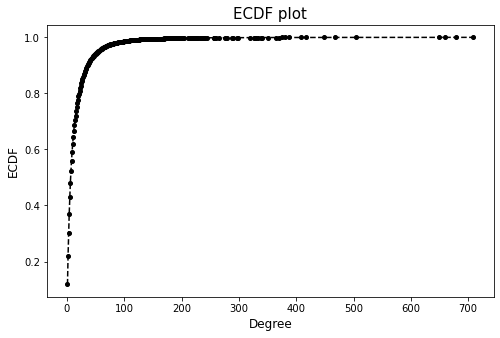

In [20]:
fig_cdf_function = plt.figure(figsize=(8,5)) 
axes = fig_cdf_function.gca()
axes.plot(x, y, color = 'black', linestyle = '--', marker = 'o',ms = 4)
axes.set_xlabel('Degree', size = 12)
axes.set_ylabel('ECDF', size = 12)
axes.set_title("ECDF plot", size=15)

Text(0.5, 1.0, 'ECDF plot')

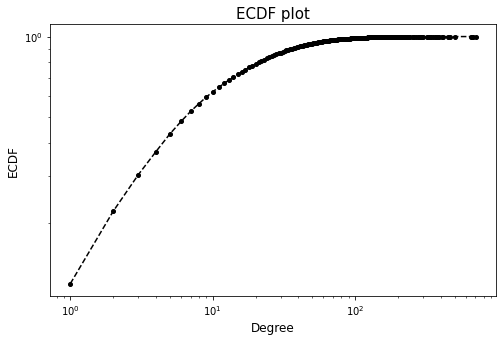

In [21]:
fig_cdf_function = plt.figure(figsize=(8,5)) 
axes = fig_cdf_function.gca()
axes.loglog(x, y, color = 'black', linestyle = '--', marker = 'o',ms = 4)
axes.set_xlabel('Degree', size = 12)
axes.set_ylabel('ECDF', size = 12)
axes.set_title("ECDF plot", size=15)

Compare to a random network (same density)

In [22]:
random_graph = nx.fast_gnp_random_graph(graph.order(),density)

In [23]:
print('Number of nodes: {}'.format(random_graph.order()))
print('Number of links: {}'.format(random_graph.size()))

Number of nodes: 22470
Number of links: 171370


In [24]:
random_degree = list(dict(random_graph.degree()).values())

In [25]:
print(f'Mean degree: {np.mean(random_degree)}')
print(f'Standard deviation: {np.std(random_degree)}')
print(f'Median: {np.median(random_degree)}')
print(f'Min: {np.min(random_degree)}')
print(f'Max: {np.max(random_degree)}')

Mean degree: 15.253226524254561
Standard deviation: 3.9100428763539403
Median: 15.0
Min: 2
Max: 34


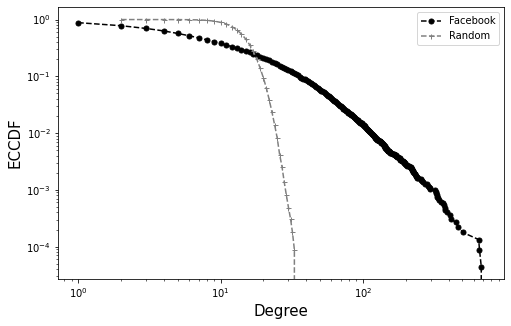

In [26]:
# ECCDF comparison
cdf_function = ECDF(degree_list)
x = np.unique(degree_list)
y = cdf_function(x)

cdf_random = ECDF(random_degree)
x_random = np.unique(random_degree)
y_random = cdf_random(x_random)

fig_cdf_function = plt.figure(figsize=(8,5))
axes = fig_cdf_function.gca()
axes.set_xscale('log')
axes.set_yscale('log')
axes.loglog(x, 1-y, color = 'black', marker = 'o', ms = 5, linestyle = '--')
axes.plot(x_random, 1-y_random, color = 'grey', marker = '+', ms = 5, linestyle = '--')
axes.set_xlabel('Degree',size = 15)
axes.set_ylabel('ECCDF', size = 15)
axes.legend(['Facebook', 'Random'])

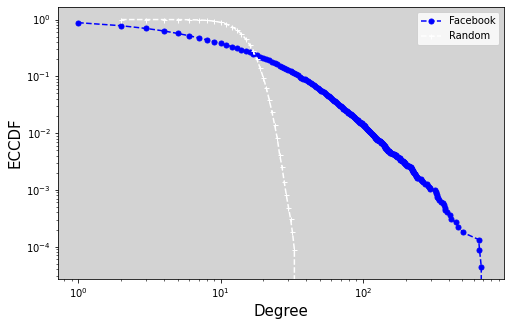

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF


# ECCDF comparison
cdf_function = ECDF(degree_list)
x = np.unique(degree_list)
y = cdf_function(x)

cdf_random = ECDF(random_degree)
x_random = np.unique(random_degree)
y_random = cdf_random(x_random)

# Create the figure
fig_cdf_function = plt.figure(figsize=(8, 5))
axes = fig_cdf_function.gca()
axes.patch.set_facecolor('lightgray')  # Set the background color

# Plot the lines with specified colors
axes.set_xscale('log')
axes.set_yscale('log')
axes.loglog(x, 1 - y, color='blue', marker='o', ms=5, linestyle='--', label='Facebook')
axes.plot(x_random, 1 - y_random, color='white', marker='+', ms=5, linestyle='--', label='Random')

# Set labels and legend
axes.set_xlabel('Degree', size=15)
axes.set_ylabel('ECCDF', size=15)
axes.legend()

# Show the plot
plt.show()

In [28]:
#HUBS: the network is a scale-free network, so hubs can be calculated
#Identify 99th percentile degree: fix the quantile in the CDF, 
#given $q \in [0,1]$ find the degree $k$ such that $F_X(k)=q$. 
#I use the Numpy function **percentile**. $q=0.99$
percentile_99 = np.percentile(degree_list,99)
print(percentile_99)
#99% of the nodes in your network have a degree less than or equal to 114. 
#In other words, it serves as a threshold or cutoff point such that only the top 1% of nodes in terms 
#of degree are considered as hubs.

114.31000000000131


In [29]:
# Identify hubs
hubs = [k for k,v in dict(degree).items() if v >= percentile_99]
print(len(hubs))
print(hubs[:10]) # first 10 in the list

225
[187, 197, 212, 290, 364, 406, 496, 701, 710, 754]


In [30]:
#Identify hubs
hubs = [(k, graph.nodes[k]['Page name'], v) for k, v in dict(degree).items() if v >= percentile_99]

#Print the first 10 hubs
print(hubs[:10])

[(187, 'Bill Shorten MP', 142), (197, 'U.S. Forest Service', 134), (212, 'Dilma Rousseff', 133), (290, 'Marie-Claude Bibeau', 174), (364, 'Loïc Hervé', 151), (406, 'NSW SES', 142), (496, 'National Park Service', 244), (701, 'Facebook', 380), (710, 'European Union in Mauritius', 115), (754, '101st Airborne Division (Air Assault)', 153)]


In [94]:
from collections import Counter
#Page type of hubs
hubs_page_types = [graph.nodes[node_id]['Page type'] for node_id, _, _ in hubs]

#How many hubs for each page type
page_type_counts = Counter(hubs_page_types)

print(page_type_counts)

Counter({'government': 174, 'politician': 43, 'company': 5, 'tvshow': 3})


In [31]:
type(degree)

networkx.classes.reportviews.DegreeView

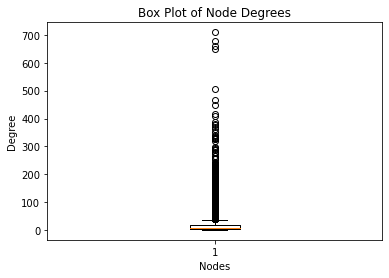

In [32]:
#Extract nodes and degrees from the DegreeView
nodes, degrees = zip(*degree)

#Create a box plot
plt.boxplot(degrees)

#Set labels and title
plt.xlabel('Nodes')
plt.ylabel('Degree')
plt.title('Box Plot of Node Degrees')

#Show the plot
plt.show()

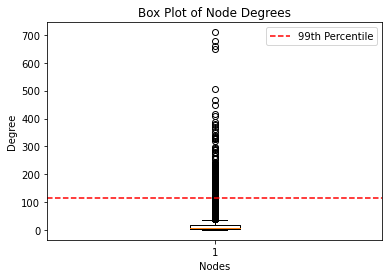

In [33]:
# Extract nodes and degrees from the DegreeView
nodes, degrees = zip(*degree)

#Create a box plot
plt.boxplot(degrees)

#Calculate the 99th percentile
percentile_99 = np.percentile(degrees, 99)

#Add a horizontal line for the 99th percentile
plt.axhline(y=percentile_99, color='r', linestyle='--', label='99th Percentile')

#Set labels and title
plt.xlabel('Nodes')
plt.ylabel('Degree')
plt.title('Box Plot of Node Degrees')

#Add a legend
plt.legend()

#Show the plot
plt.show()

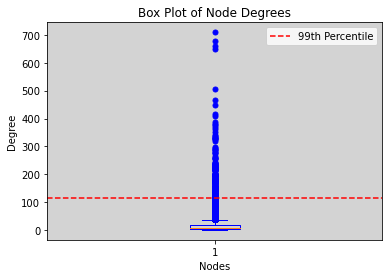

In [34]:
#Extract nodes and degrees from the DegreeView
nodes, degrees = zip(*degree)

#Create a box plot
fig, ax = plt.subplots()

#Set background color
ax.set_facecolor('lightgray')

#Set box color to blue
boxprops = dict(color='blue')
flierprops = dict(markeredgecolor='blue', markerfacecolor='blue', markersize=5)
whiskerprops = dict(color='blue')
capprops = dict(color='blue')

ax.boxplot(degrees, boxprops=boxprops, flierprops=flierprops, whiskerprops=whiskerprops, capprops=capprops)

#Calculate the 99th percentile
percentile_99 = np.percentile(degrees, 99)

#Add a horizontal line for the 99th percentile
ax.axhline(y=percentile_99, color='r', linestyle='--', label='99th Percentile')

#Set labels and title
ax.set_xlabel('Nodes')
ax.set_ylabel('Degree')
ax.set_title('Box Plot of Node Degrees')

#Add a legend
ax.legend()

#Show the plot
plt.show()

Connectivity

In [71]:
print(nx.is_connected(graph))
print(nx.number_connected_components(graph))

True
1


In [73]:
largest_cc = max(nx.connected_components(graph), key=len)

In [74]:
print(len(largest_cc))

22470


Transitivity

In [35]:
nx.transitivity(graph)

0.23232143653859755

In [36]:
nx.average_clustering(graph), np.mean(list(nx.clustering(graph).values()))

(0.3597383824426918, 0.3597383824426949)

In [37]:
np.median(list(nx.triangles(graph).values()))

6.0

Assortativity

In [38]:
#Attribute assortativity
nx.attribute_assortativity_coefficient(graph, attribute= "Page type", nodes=None)

0.8207604936489163

In [39]:
MM = nx.attribute_mixing_matrix(graph, attribute = "Page type", nodes=None, mapping=None, normalized=True)

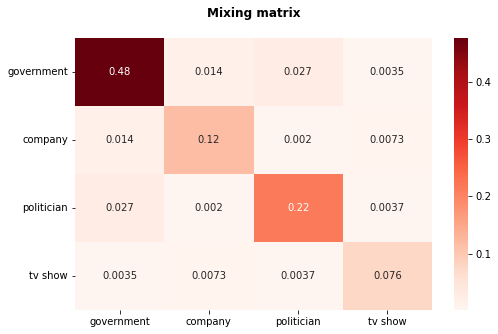

In [40]:
plt.figure(figsize = (8,5))
clusters = ['government', 'company', 'politician', 'tv show']
sns.heatmap(pd.DataFrame(MM),annot = True,cmap = 'Reds')
plt.xticks([x+0.5 for x in range(4)],clusters, rotation = 0)
plt.yticks([x+0.5 for x in range(4)],clusters, rotation = 0)
plt.title('Mixing matrix\n', weight = 'bold')
plt.show()

In [41]:
nx.degree_assortativity_coefficient(graph)

0.08505802105736318

Community detection

In [42]:
#Detecting communities or clusters in a network.
partition_louvain = louvain.best_partition(graph)
#The result is a dictionary where keys are node and the values are the assigned 
#community labels

In [43]:
list_community_sets_louvain= defaultdict(set)
for n, comm in partition_louvain.items():
    list_community_sets_louvain[comm].add(n)

In [58]:
comm_len = [(c, len(nodes)) for c,nodes in list_community_sets_louvain.items()]
comm_len.sort(key = lambda x: x[1],reverse = True)
#Detecting of communities and ordering them in descending based on their sizes
len(comm_len)

59

In [59]:
comm_len

[(12, 3404),
 (9, 1347),
 (14, 1325),
 (8, 1220),
 (4, 1107),
 (16, 1068),
 (18, 963),
 (28, 938),
 (6, 862),
 (27, 848),
 (5, 807),
 (1, 721),
 (21, 562),
 (19, 530),
 (17, 525),
 (23, 522),
 (15, 521),
 (11, 474),
 (13, 419),
 (20, 332),
 (22, 330),
 (32, 261),
 (2, 257),
 (10, 250),
 (43, 250),
 (33, 242),
 (34, 208),
 (36, 174),
 (7, 171),
 (24, 155),
 (30, 153),
 (37, 149),
 (0, 147),
 (31, 145),
 (38, 145),
 (44, 125),
 (29, 111),
 (52, 96),
 (42, 81),
 (45, 58),
 (58, 55),
 (41, 48),
 (49, 38),
 (53, 37),
 (35, 35),
 (39, 34),
 (47, 27),
 (50, 23),
 (55, 23),
 (56, 23),
 (51, 21),
 (54, 21),
 (46, 14),
 (40, 14),
 (25, 14),
 (3, 12),
 (26, 10),
 (48, 9),
 (57, 9)]

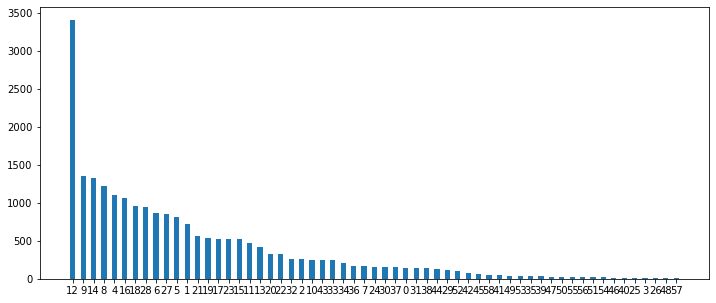

In [46]:
plt.figure(figsize = (12,5))
plt.bar(range(len(comm_len)), [x[1] for x in comm_len],width = 0.5)
plt.xticks(range(len(comm_len)), [x[0] for x in comm_len])
plt.show()

In [47]:
nx.set_node_attributes(graph, partition_louvain, 'community')

In [48]:
df_graph = pd.DataFrame.from_dict(graph.nodes, orient='index')

In [49]:
df_graph
#Each row corresponds to a node in the graph and the columns represents node attributes

,Page name,Page type,community
0,The Voice of China 中国好声音,tvshow,17
1,U.S. Consulate General Mumbai,government,1
2,ESET,company,2
3,Consulate General of Switzerland in Montreal,government,0
4,Mark Bailey MP - Labor for Miller,politician,4
...,...,...,...
22465,Kurt Wiegel MdL,politician,21
22466,dubdub Stories,company,12
22467,Ministerio del Interior - Paraguay,government,1
22468,Tottus Perú,company,19


In [64]:
type(df_graph)


pandas.core.frame.DataFrame

In [84]:
#Filter rows where 'community' is equal to 12
df_community_12 = df_graph[df_graph['community'] == 12]

#Display the resulting DataFr
df_community_12

#Page type of community 12
page_types_community_12 = df_community_12['Page type'].unique()

print("Tipi di pagine nella community 12:")
print(page_types_community_12)

Tipi di pagine nella community 12:
['company' 'tvshow' 'government' 'politician']


In [86]:
#How many elements for each page type in 12
page_type_counts = df_community_12['Page type'].value_counts()

print("Conteggio per ogni tipo di pagina nella community 12:")
print(page_type_counts)

Conteggio per ogni tipo di pagina nella community 12:
company       2119
tvshow        1249
government      26
politician      10
Name: Page type, dtype: int64


In [87]:
df_community_12

,Page name,Page type,community,Count
16,Die Techniker (TK),company,12,1
30,TeleCentro,company,12,1
35,Omoda,company,12,1
36,Sunrun,company,12,1
42,Honey Bunches of Oats,company,12,1
...,...,...,...,...
22433,CVS Pharmacy,company,12,1
22446,Triumph,company,12,1
22454,Premier Boxing Champions,tvshow,12,1
22464,Keurig,company,12,1


In [91]:
#First 20 rows of df_community_12
df_community_12_tvshows = df_community_12[df_community_12['Page type'] == 'tvshow'].head(60)

print(df_community_12_tvshows[['Page name', 'Page type']])

                                     Page name Page type
70                              Modern Marvels    tvshow
96          Noticias Univision Florida Central    tvshow
111                         Inside Amy Schumer    tvshow
117                                    RECLAME    tvshow
140                                SoFlo TASTE    tvshow
141                               White Collar    tvshow
185                            Ghost Whisperer    tvshow
233                             Covert Affairs    tvshow
258                                 The Profit    tvshow
264                         Man v. Food Nation    tvshow
267                                  Superbook    tvshow
274                             Fashion Queens    tvshow
298   The Secret Life of the American Teenager    tvshow
367                                     Motive    tvshow
397                              The Chase USA    tvshow
434                                 Common Law    tvshow
450                         Myr

In [70]:
degree_list[22464]

17

In [50]:
df_graph['Count'] = 1
#Add a column Count with value 1 for each row

In [51]:
table = pd.pivot_table(df_graph, values='Count', index=['community'], columns=['Page type'], aggfunc=np.sum)
table = table.fillna(0)

In [52]:
table

Page type,company,government,politician,tvshow
community,,,,
0,23.0,57.0,2.0,65.0
1,48.0,471.0,167.0,35.0
2,155.0,50.0,24.0,28.0
3,12.0,0.0,0.0,0.0
4,108.0,338.0,532.0,129.0
5,64.0,321.0,382.0,40.0
6,32.0,182.0,550.0,98.0
7,0.0,152.0,19.0,0.0
8,40.0,1148.0,16.0,16.0


In [53]:
table['company'] = table['company']/sum(table['company'])
table['government'] = table['government']/sum(table['government'])
table['politician'] = table['politician']/sum(table['politician'])
table['tvshow'] = table['tvshow']/sum(table['tvshow'])
round(100*table,1)

Page type,company,government,politician,tvshow
community,,,,
0,0.4,0.8,0.0,2.0
1,0.7,6.8,2.9,1.1
2,2.4,0.7,0.4,0.8
3,0.2,0.0,0.0,0.0
4,1.7,4.9,9.2,3.9
5,1.0,4.7,6.6,1.2
6,0.5,2.6,9.5,2.9
7,0.0,2.2,0.3,0.0
8,0.6,16.7,0.3,0.5


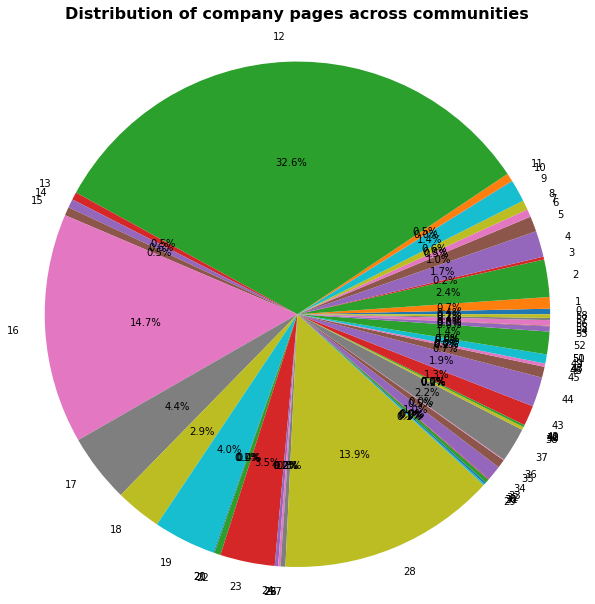

In [78]:
fig1, ax1 = plt.subplots(figsize =(10, 10))
ax1.pie(100*table['company'], labels=table.index, autopct='%1.1f%%')
ax1.axis('equal')
title_font = {'fontsize': 16, 'fontweight': 'bold'}
plt.title("Distribution of company pages across communities\n", fontdict=title_font)
plt.savefig("company_distribution.png")
plt.show()

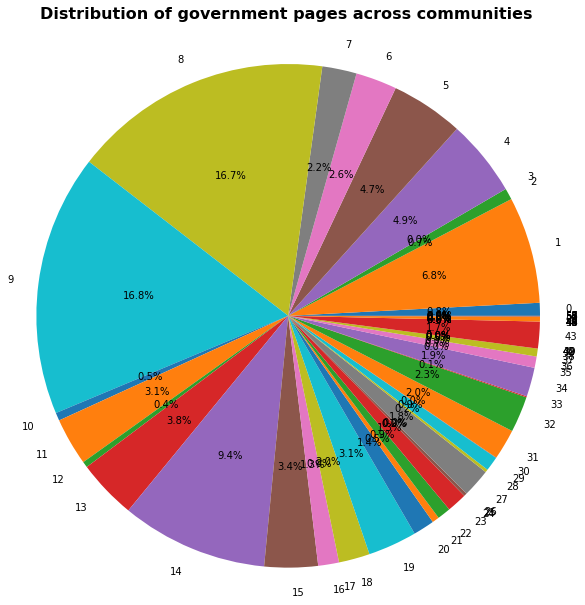

In [79]:
fig1, ax1 = plt.subplots(figsize =(10, 10))
ax1.pie(100*table['government'], labels=table.index, autopct='%1.1f%%')
ax1.axis('equal')
title_font = {'fontsize': 16, 'fontweight': 'bold'}
plt.title("Distribution of government pages across communities\n", fontdict=title_font)
plt.savefig("government_distribution.png")
plt.show()

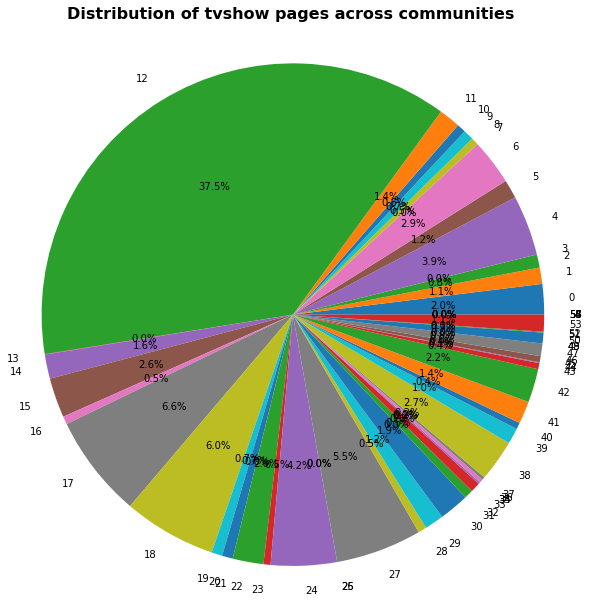

In [80]:
fig1, ax1 = plt.subplots(figsize =(10, 10))
ax1.pie(100*table['tvshow'], labels=table.index, autopct='%1.1f%%')
ax1.axis('equal')
title_font = {'fontsize': 16, 'fontweight': 'bold'}
plt.title("Distribution of tvshow pages across communities\n", fontdict=title_font)
plt.savefig("tvshow_distribution.png")
plt.show()

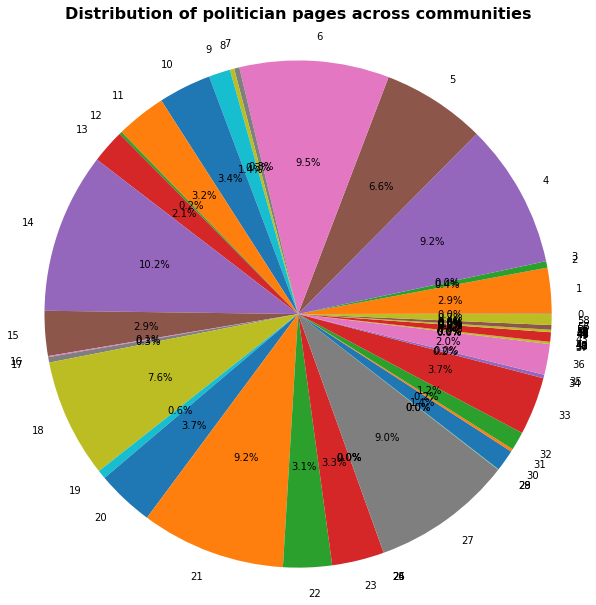

In [81]:
fig1, ax1 = plt.subplots(figsize =(10, 10))
ax1.pie(100*table['politician'], labels=table.index, autopct='%1.1f%%')
ax1.axis('equal')
title_font = {'fontsize': 16, 'fontweight': 'bold'}
plt.title("Distribution of politician pages across communities\n", fontdict=title_font)
plt.savefig("politician_distribution.png")
plt.show()

In [56]:
nx.set_node_attributes(graph, partition_louvain, 'community')

In [75]:
nx.write_gexf(G = graph, path = 'facebook_graph.gexf')